In [1]:
adfile_path = r"C:\Users\21lyb\Downloads\PBMC_simulated_cnas_041025.h5ad"

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
from biomart import BiomartServer
from io import StringIO
import anndata as ad
import warnings

warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

sc.logging.print_header()

c:\Users\21lyb\Documents\CSCB-2025-Final\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


numpy	1.26.4
pandas	2.2.3
scanpy	1.11.1
infercnvpy	0.6.0
matplotlib	3.10.0
biomart	0.9.2
anndata	0.11.4
----	----
asttokens	3.0.0
jupyter_core	5.7.2
pure-eval	0.2.2
legacy-api-wrap	1.4.1
pytz	2025.2
pywin32	308
idna	3.10
jedi	0.19.2
llvmlite	0.44.0
pillow	11.2.1 (9.4.0)
wcwidth	0.2.5
defusedxml	0.7.1
pyparsing	3.2.0
colorama	0.4.6
tornado	6.4.2
platformdirs	4.3.7
threadpoolctl	3.6.0
matplotlib-inline	0.1.6
setuptools	75.8.0
Pygments	2.19.1
debugpy	1.8.11
Pillow	11.2.1 (9.4.0)
joblib	1.4.2
igraph	0.11.8
executing	0.8.3
certifi	2025.4.26 (2025.04.26)
pyzmq	26.2.0
pycairo	1.28.0
decorator	5.1.1
cffi	1.17.1
Brotli	1.0.9
psutil	5.9.0
parso	0.8.4
scipy	1.15.2
six	1.17.0
comm	0.2.1
python-dateutil	2.9.0.post0
ipykernel	6.29.5
kiwisolver	1.4.8
PyYAML	6.0.2
stack-data	0.2.0
texttable	1.7.0
scikit-learn	1.5.2
natsort	8.4.0
ipython	9.1.0
leidenalg	0.10.2
requests	2.32.3
tqdm	4.67.1
charset-normalizer	3.4.1
typing_extensions	4.13.2
cycler	0.11.0 (0.12.1)
pyreadr	0.5.3
packaging	24.2
urllib3	2.4.0
numba	0.61.2
jupyter_client	8.6.3
traitlets	5.14.3
h5py	3.9.0
session-info2	0.1.2
prompt-toolkit	3.0.43
----	----
Python	3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:29:11) [MSC v.1935 64 bit (AMD64)]
OS	Windows-10-10.0.26100-SP0
CPU	12 logical CPU cores, Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
GPU	ID: 0, NVIDIA GeForce GTX 1650 Ti, Driver: 560.70, Memory: 4096 MiB
Updated	2025-05-01 18:50

In [3]:
# Functions
def qc(adata,
    mt_threshold_pct=20,
    min_genes=200,
    max_counts=50000,
    min_cells=3):

    adata1 = adata.copy()

    # Find MT genes
    adata1.var['mt'] = adata1.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'],
                            percent_top=None,
                            log1p=False,
                            inplace=True)

    # Filter out cells based on MT genes
    adClean = adata1[adata1.obs['pct_counts_mt']<mt_threshold_pct,:].copy()

    # Filter out cells based on number of genes expressed
    sc.pp.filter_cells(adClean, min_genes=min_genes)

    # Filter out cells based on total counts
    sc.pp.filter_cells(adClean, max_counts=max_counts)

    # Filter out genes expressed in few cells
    sc.pp.filter_genes(adClean, min_cells=min_cells)

    return adClean

def preprocess(adata,
               min_mean=0.0125,
               max_mean=6,
               min_disp=0.25):
    
    adNorm = adata.copy()

    # Normalize and log transform
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Detect highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)

    # PCA
    sc.tl.pca(adata, use_highly_variable=True)
    sc.pl.pca_variance_ratio(adata,50)

    return adNorm

def KNN(adata, n_neighbors=20, n_pcs=10, annotation="cell_type"):
    sc.pp.neighbors(adata,n_neighbors=n_neighbors,n_pcs=n_pcs)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=annotation)

def downsample(adata,n_cells):
    if adata.n_obs <= n_cells:
        return adata
    else:
        return adata[np.random.choice(adata.obs_names, n_cells, replace=False), :].copy()

def fetch_positions(adata):
    # Connect to Ensembl Biomart server
    server = BiomartServer("http://grch37.ensembl.org/biomart")
    dataset = server.datasets['hsapiens_gene_ensembl']

    # Query gene names for only missing gene positions
    no_positions = adata[:, adata.var[['start', 'end']].isna().any(axis=1)]
    with_positions = adata[:, ~adata.var[['start', 'end']].isna().any(axis=1)]
    response = dataset.search({
        'filters':{'ensembl_gene_id':list(no_positions.var['gene_ids'])},
        'attributes':['ensembl_gene_id','chromosome_name','start_position','end_position','strand']
    })

    # Convert response to DataFrame and merge with adata.var if response is successful
    if response.status_code == 200:
        print("Request successful!")
        gene_annotations_df = pd.read_csv(StringIO(response.text),sep='\t',header=None)
        gene_annotations_df.columns = ['gene_ids','chromosome','start','end','strand']
    else:
        print(f"Request failed with status code: {response.status_code}")
        print(response.text)

    # Isolate fetched genes from BioMart in no_positions adata
    fetched_positions = no_positions[:, no_positions.var['gene_ids'].isin(gene_annotations_df['gene_ids'])].copy()

    # Sort fetched genes based on ensembl gene IDs
    fetched_positions = fetched_positions[:, fetched_positions.var['gene_ids'].argsort()].copy()

    # Add the fetched gene positions to the adata
    fetched_positions.var['chromosome'] = gene_annotations_df['chromosome'].values
    fetched_positions.var['start'] = gene_annotations_df['start'].values
    fetched_positions.var['end'] = gene_annotations_df['end'].values
    fetched_positions.var['strand'] = gene_annotations_df['strand'].values

    # Concatenate fetched genes with isolated genes already with positions
    adClean = ad.concat([with_positions, fetched_positions], axis=1)

    # Include obs into the cleaned adata
    adClean.obs = with_positions.obs.copy()

    return adClean

def standardize_chromosomes(adata):
    
    adata1 = adata.copy()

    # Add 'chr' prefix to chromosome names
    adata1.var['chromosome'] = 'chr' + adata1.var['chromosome'].astype(str)

    # Define standard chromosome names with 'chr' prefix
    standard_chromosomes = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY', 'chrMT']

    # Filter adata to include only genes on standard chromosomes
    adata1 = adata1[:, adata1.var['chromosome'].isin(standard_chromosomes)].copy()

    return adata1

def infer_cnas(adata,reference_key='cell_type',reference_cat=[]):

    # Check if reference categories are provided, if not, use unique categories from the adata
    if len(reference_cat) == 0:
        reference_cat = list(adata.obs[reference_key].unique())

    # Run InferCNVpy
    cnv.tl.infercnv(adata,reference_key=reference_key,reference_cat=reference_cat,exclude_chromosomes=None)

In [4]:
adata = sc.read_h5ad(adfile_path)

In [5]:
# Run if needed:
# adata = qc(adata)
# adata = downsample(adata,n_cells=2000)

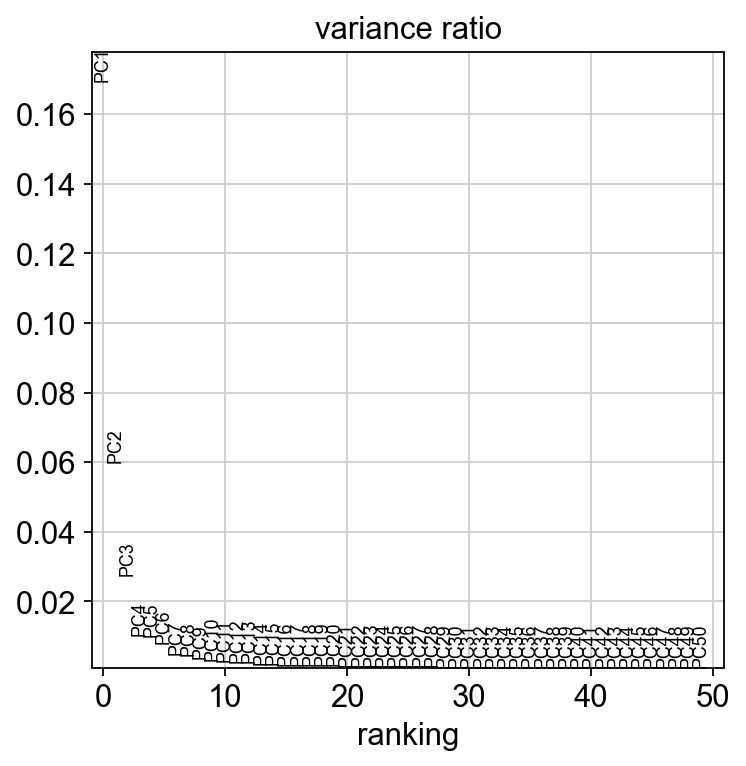

In [6]:
adata = preprocess(adata)

In [7]:
adata = fetch_positions(adata)

Request successful!


In [8]:
adata = standardize_chromosomes(adata)

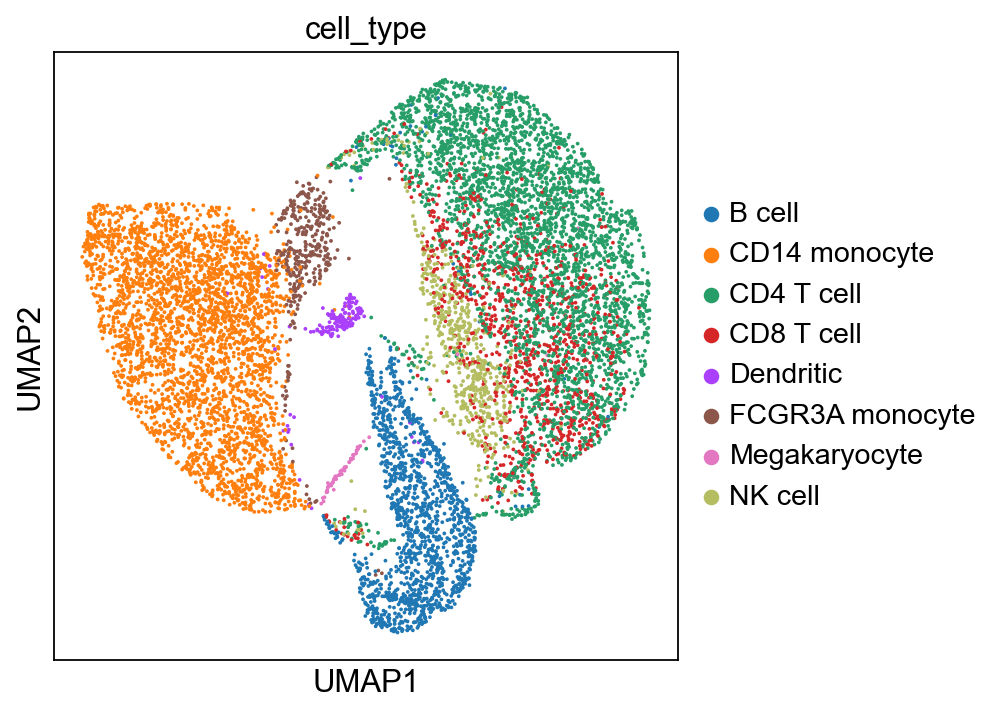

In [9]:
KNN(adata,n_pcs=10)

In [10]:
infer_cnas(adata,reference_key='cell_type')

100%|██████████| 3/3 [00:11<00:00,  3.69s/it]


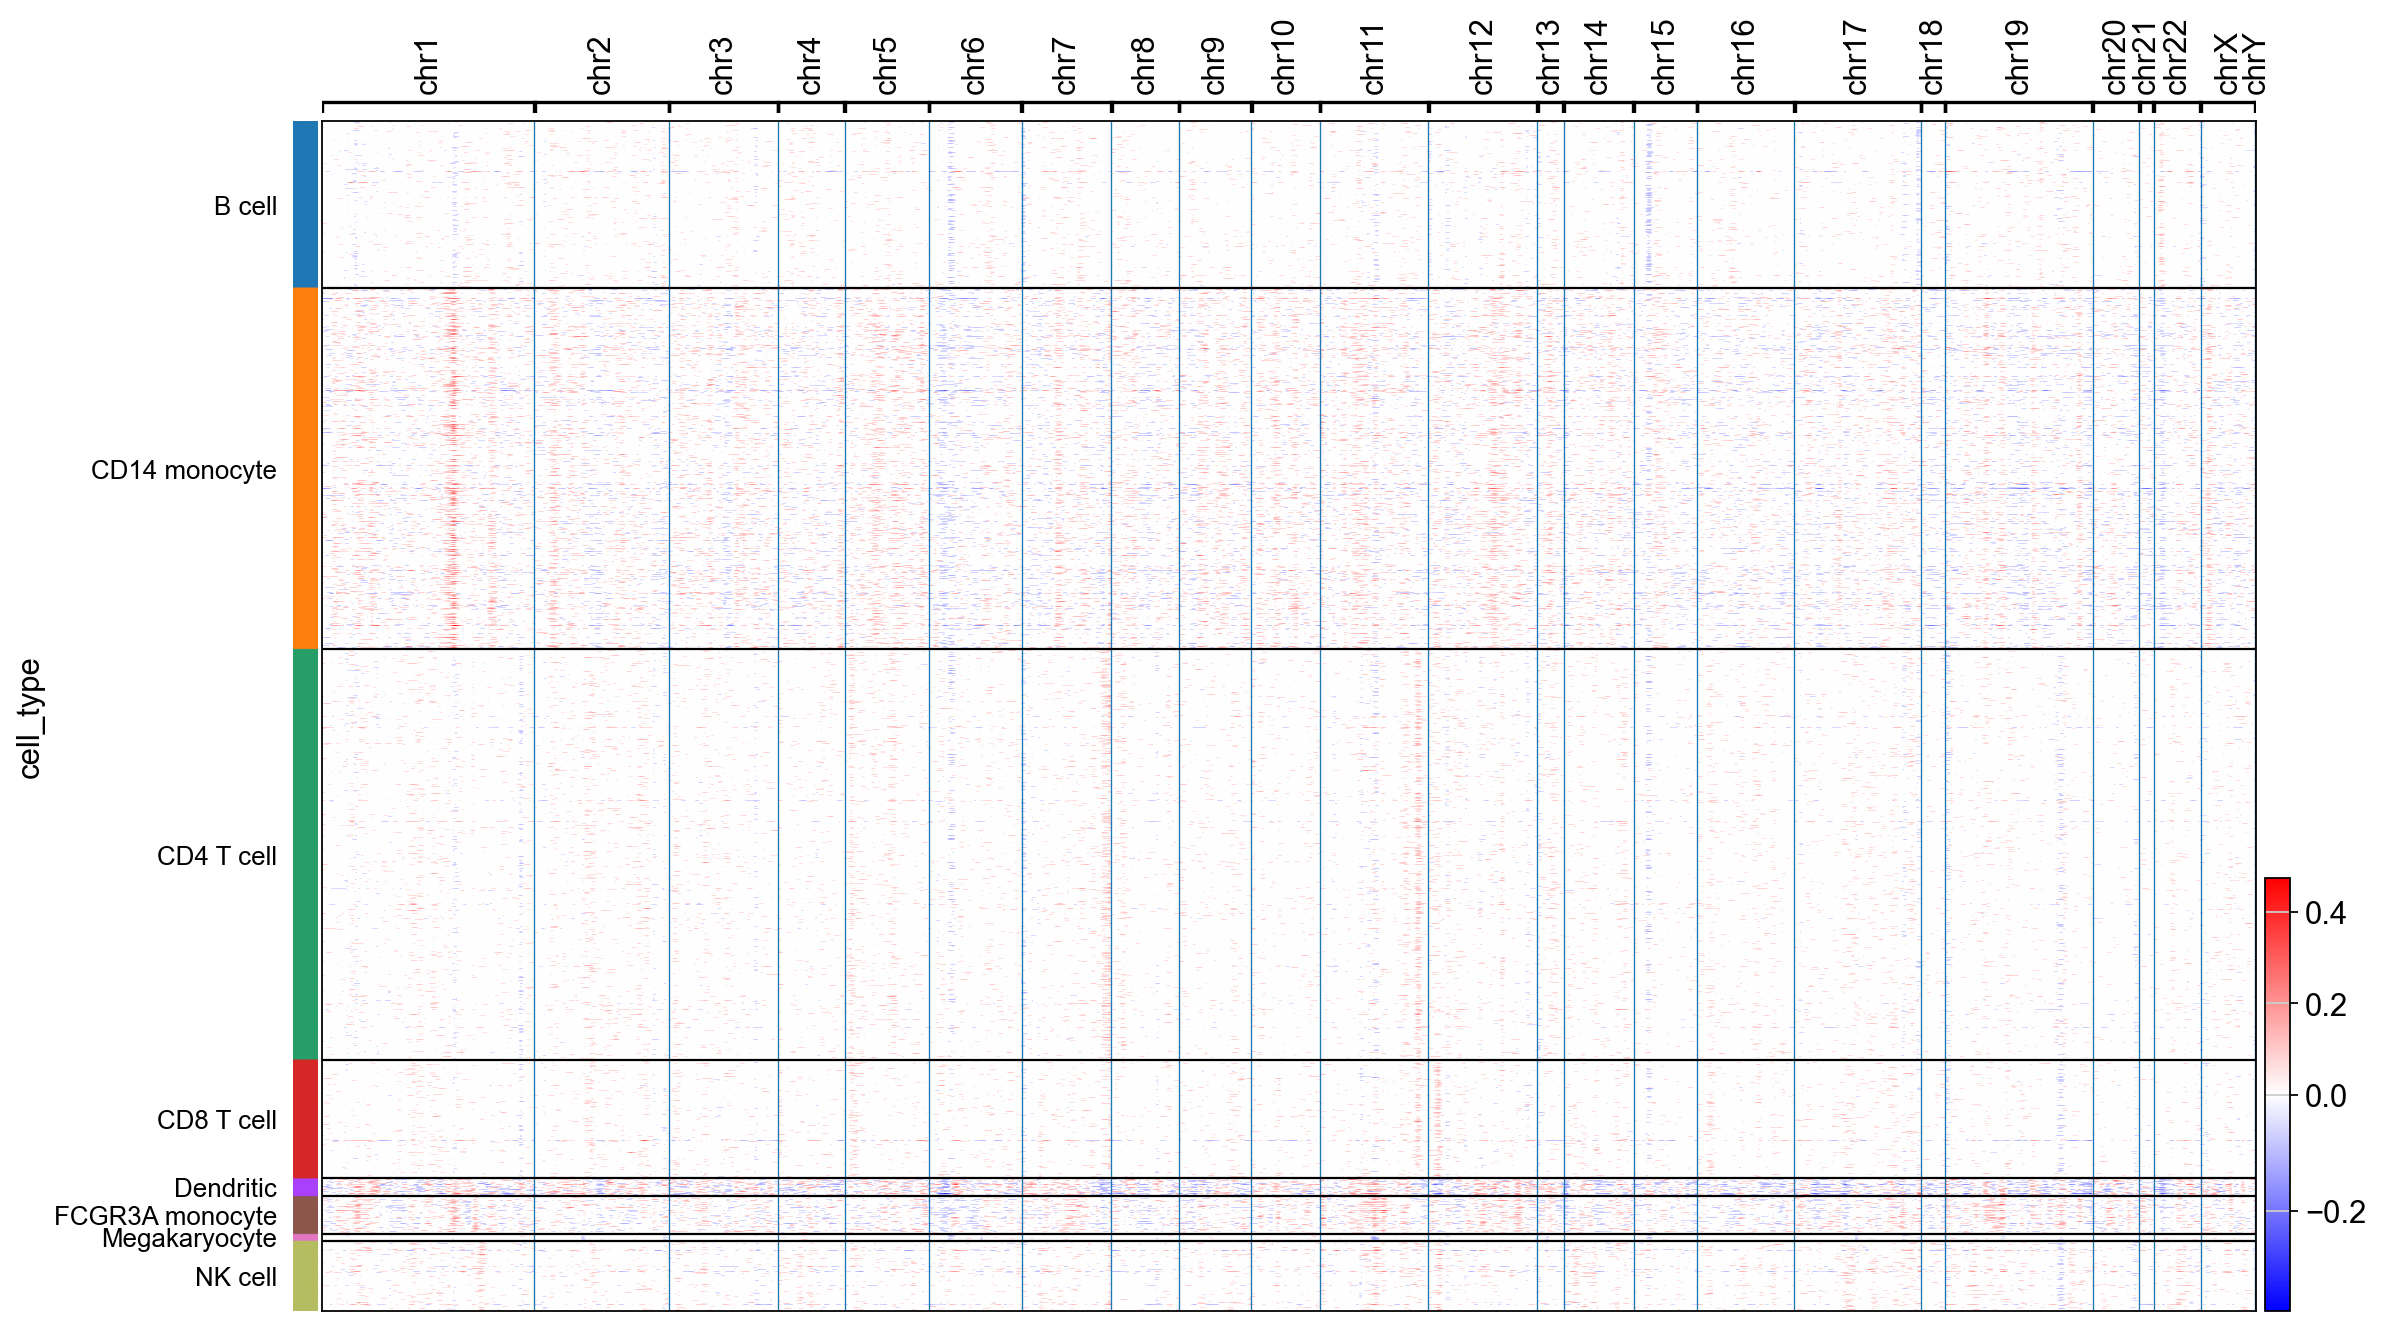

In [11]:
# Plot smoothed gene expression by cell type and chromosome
cnv.pl.chromosome_heatmap(adata, groupby="cell_type")

# You can observe that CD14 monocytes have significant decrease in expression of genes on chr6 and chr22
# (more blue/less red than genes on other chromosomes with enough genes for comparison)
# which is expected given the simulated chr6 and chr22 loss CNAs in CD14 monocytes

# The simulated CNA chrX gain is harder to see on the heatmap
# But if you zoom in you can see not many genes in blue
# which may indicate higher expression of genes on chrX

In [12]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


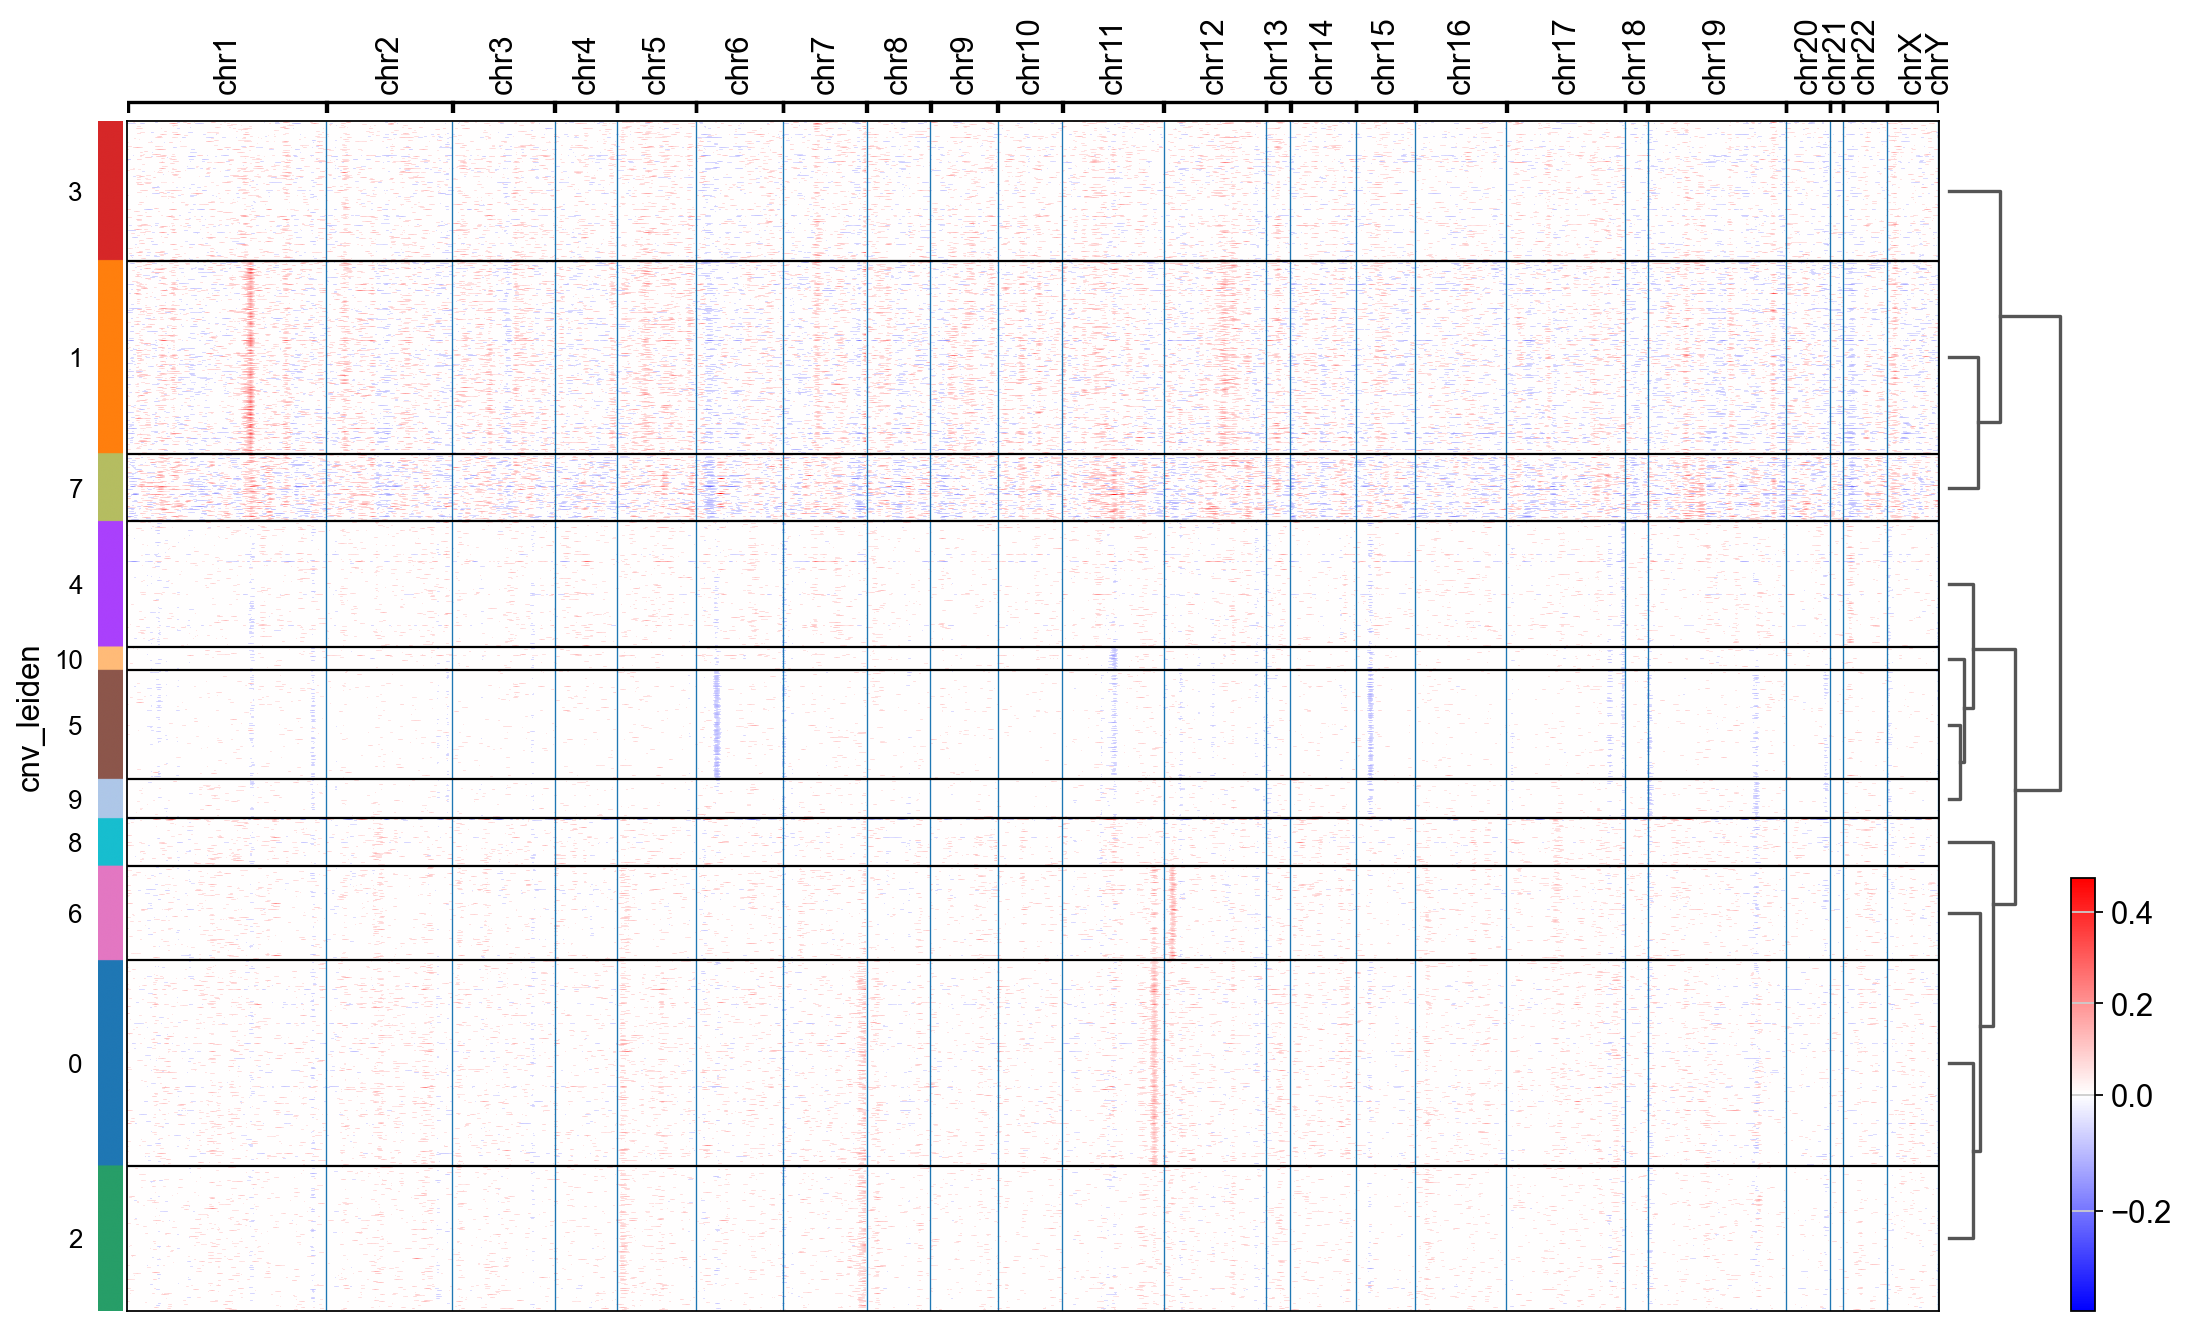

In [13]:
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)

In [14]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

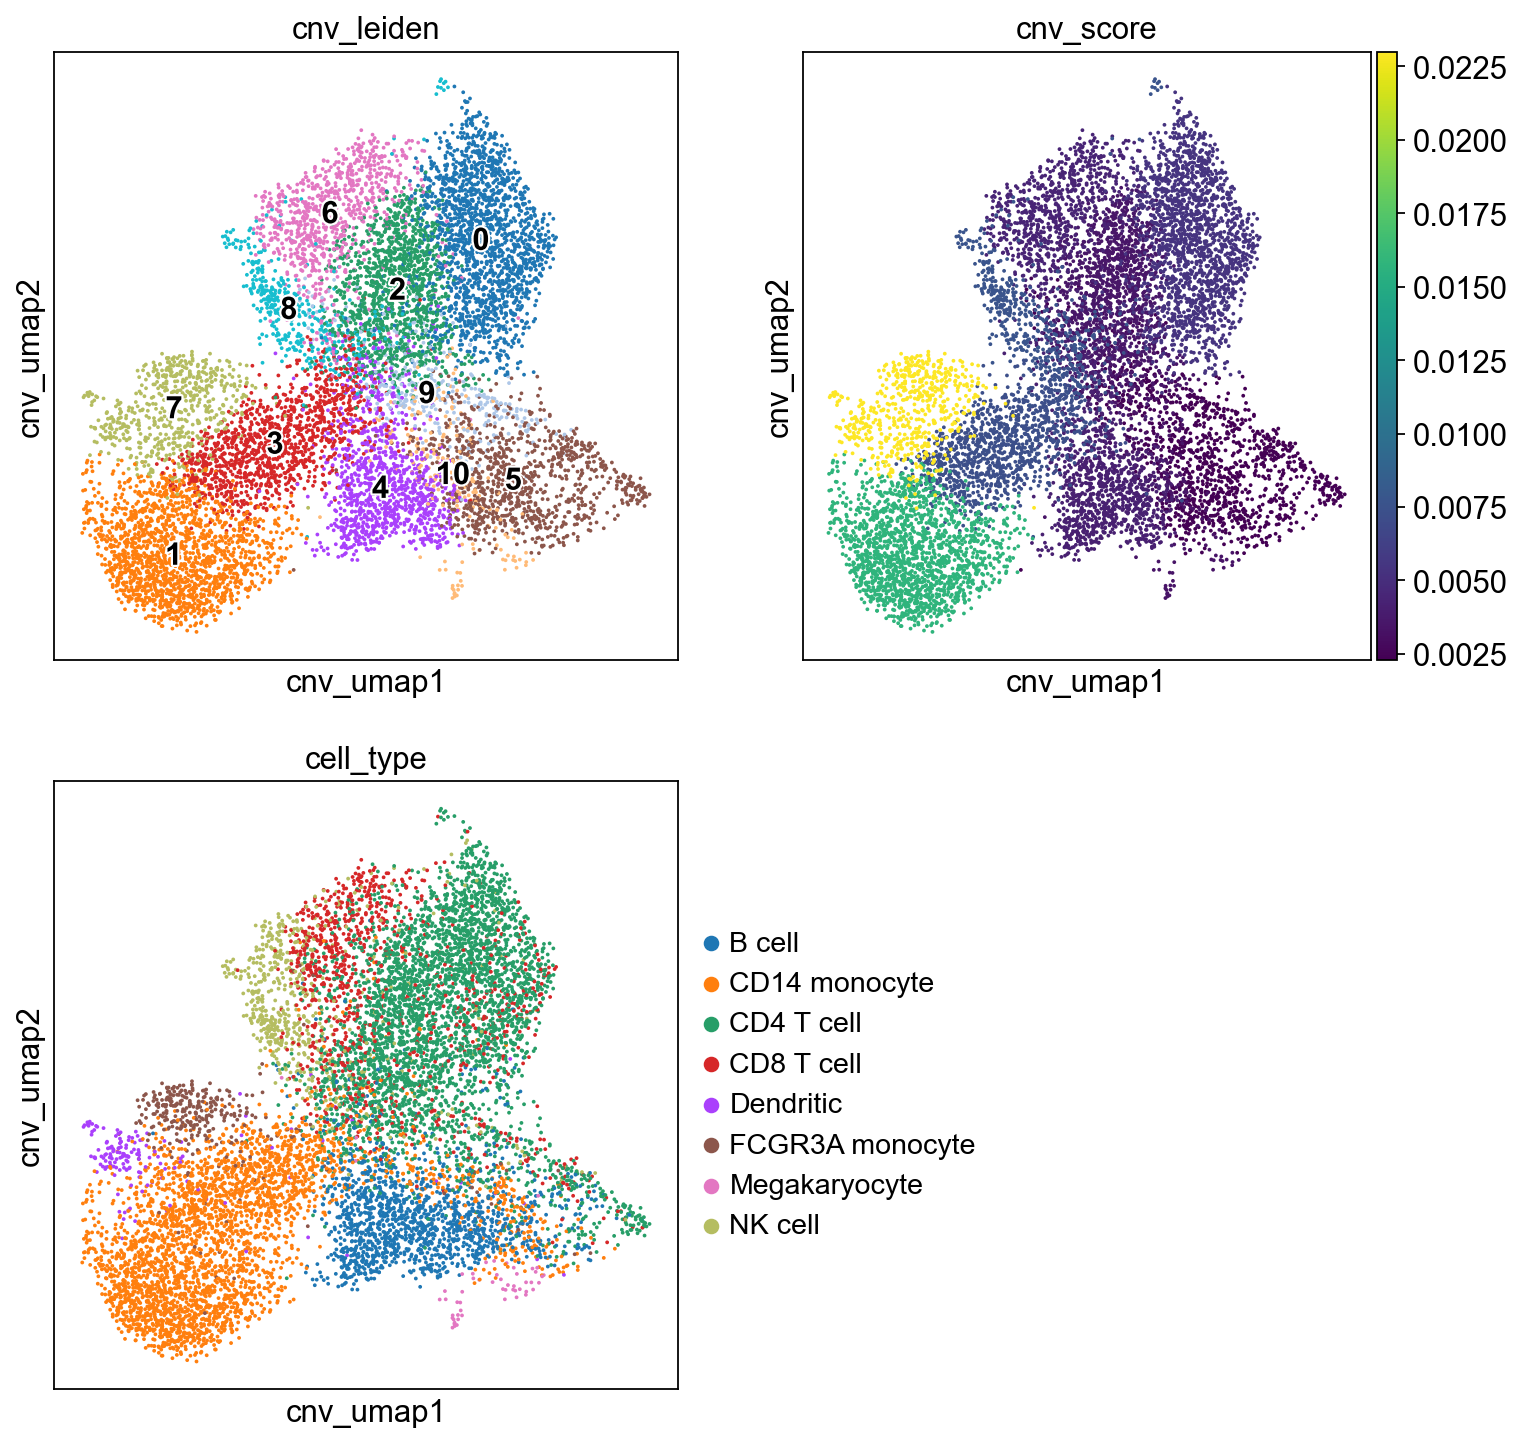

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata, color="cell_type", ax=ax3)

# Possible CNV clusters: 0,1,3,7,8

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 11), gridspec_kw={"wspace": 0.5})
ax4.axis("off")
sc.pl.umap(adata, color="cnv_leiden", ax=ax1, show=False)
sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
sc.pl.umap(adata, color="cell_type", ax=ax3)

# Possible CNV clusters: 0,1,3,7,8
# Possible CNV cell types: CD14 monocyte, CD4 T cell, CD16 monocyte, NK cell
# Actual simulated CNVs:
# - CD14 monocytes: Chr6 loss, Chr22 loss
# - CD4 T cells: ChrX gain

In [ ]:
# Next steps:
# - Be able to set a threshold for CNV score to automatically select CNV cell
#    - A fraction of the maximum CNV score
# - Of all the cells in a CNV cluster, assign a selected chromosome where the CNV takes place
#    - Could be done by comparing average expression of all genes per chromosome
#      for the cells in that CNV cluster, and compare it to the average expression of all genes
#      per chromosome for all cells in the dataset
#    - Ensure there is enough genes in a chromosome to make a comparison
# - Find a way to get a genomic range (start, end) for the CNV
# - Format CNV column in adata.obs
# - If desired, replace current gene positions function with infercnvpy.io.genomic_position_from_biomart
# - Verify if infercnvpy PCA and neighbors functions should be ran after infercnvpy.tl.infercnv

In [18]:
# Set a threshold for CNV score
threshold_fraction = 0.3
cnv_score_threshold = threshold_fraction * adata.obs['cnv_score'].max()

In [19]:
# Identify cells with CNVs over the threshold
adata.obs['has_cnv'] = adata.obs['cnv_score'] > cnv_score_threshold

In [ ]:
# Assign chromosomes to cells with CNVs over the threshold
# This may be done either on the cell scale or cnv cluster scale
def assign_cnv_chromosome(adata,cnv_column='has_cnv'):
    # list of avg expression per chromosome in the entire dataset
    # For each cell that has a CNV
        # list of avg expression per chromosome
            # if # genes in chromosome is under a threshold, set expression to 0
        # list of differences: avg expression per chromosome in cell - in entire dataset
            # if # genes in chromosome is under a threshold, set expression to 0
        # find chromosome with the highest magnitude of difference
            # if diff>0, gain. if diff<0, loss
        # may set another threshold to determine if this difference is significant to be CNV
    
    return

n_genes_by_counts  total_counts  total_counts_ribo  \
AAACCCAAGCGCCCAT-1               1005        1760.0              392.0   
AAACCCAAGGTTCCGC-1               4101       14240.0             4526.0   
AAACCCACAGAGTTGG-1               1742        4208.0             1043.0   
AAACCCACAGGTATGG-1               2122        4354.0              742.0   
AAACCCACATAGTCAC-1               1521        2819.0             1734.0   
...                               ...           ...                ...   
TTTGTTGGTGCGTCGT-1               1245        2279.0             2471.0   
TTTGTTGGTGTCATGT-1               1245        2548.0              606.0   
TTTGTTGGTTTGAACC-1               1308        2468.0             1402.0   
TTTGTTGTCCAAGCCG-1               1577        3093.0             1985.0   
TTTGTTGTCTTACTGT-1               1653        3305.0             2932.0   

                    pct_counts_ribo  total_counts_mt  pct_counts_mt  n_genes  \
AAACCCAAGCGCCCAT-1        17.785845             52.0       2.359347     1005   
AAACCCAAGGTTCCGC-1        22.528622           1324.0       6.590343     4101   
AAACCCACAGAGTTGG-1        17.726036            633.0      10.757988     1742   
AAACCCACAGGTATGG-1        13.417721            434.0       7.848101     2122   
AAACCCACATAGTCAC-1        33.960049            553.0      10.830396     1521   
...                             ...              ...            ...      ...   
TTTGTTGGTGCGTCGT-1        48.308895            365.0       7.135875     1245   
TTTGTTGGTGTCATGT-1        15.392430            783.0      19.888241     1245   
TTTGTTGGTTTGAACC-1        33.027092            375.0       8.833922     1308   
TTTGTTGTCCAAGCCG-1        35.433773            524.0       9.353803     1577   
TTTGTTGTCTTACTGT-1        43.392036            520.0       7.695724     1653   

                    n_counts      cell_type  \
AAACCCAAGCGCCCAT-1    1760.0     CD4 T cell   
AAACCCAAGGTTCCGC-1   14240.0      Dendritic   
AAACCCACAGAGTTGG-1    4208.0  CD14 monocyte   
AAACCCACAGGTATGG-1    4354.0        NK cell   
AAACCCACATAGTCAC-1    2819.0         B cell   
...                      ...            ...   
TTTGTTGGTGCGTCGT-1    2279.0     CD4 T cell   
TTTGTTGGTGTCATGT-1    2548.0  CD14 monocyte   
TTTGTTGGTTTGAACC-1    2468.0     CD8 T cell   
TTTGTTGTCCAAGCCG-1    3093.0     CD4 T cell   
TTTGTTGTCTTACTGT-1    3305.0     CD4 T cell   

                                                       simulated_cnvs  \
AAACCCAAGCGCCCAT-1                                                      
AAACCCAAGGTTCCGC-1                                                      
AAACCCACAGAGTTGG-1                        22:19807132-29743868 (CN 0)   
AAACCCACAGGTATGG-1                                                      
AAACCCACATAGTCAC-1                                                      
...                                                               ...   
TTTGTTGGTGCGTCGT-1                                                      
TTTGTTGGTGTCATGT-1  22:19807132-29743868 (CN 0), 6:25435484-350352...   
TTTGTTGGTTTGAACC-1                                                      
TTTGTTGTCCAAGCCG-1                       X:106533974-112956833 (CN 4)   
TTTGTTGTCTTACTGT-1                                                      

                   cnv_leiden  cnv_score  has_cnv  
AAACCCAAGCGCCCAT-1         10   0.003377    False  
AAACCCAAGGTTCCGC-1          7   0.023010     True  
AAACCCACAGAGTTGG-1          1   0.015753     True  
AAACCCACAGGTATGG-1          8   0.007720     True  
AAACCCACATAGTCAC-1          4   0.004129    False  
...                       ...        ...      ...  
TTTGTTGGTGCGTCGT-1          2   0.003487    False  
TTTGTTGGTGTCATGT-1          5   0.002383    False  
TTTGTTGGTTTGAACC-1          6   0.004338    False  
TTTGTTGTCCAAGCCG-1          2   0.003487    False  
TTTGTTGTCTTACTGT-1          2   0.003487    False  

[10309 rows x 13 columns]

In [19]:
# Simulated CNV information in dataset
# chr#:genomic range (CN #))
# CN 0: complete deletion
# CN 1: partial deletion
# CN 4: gain
np.unique(list(adata.obs['simulated_cnvs']))

array(['', '22:19807132-29743868 (CN 0)',
       '22:19807132-29743868 (CN 0), 6:25435484-35035259 (CN 1)',
       '6:25435484-35035259 (CN 1)', 'X:106533974-112956833 (CN 4)'],
      dtype='<U55')